In [1]:
from dask.distributed import Client
# from dask_jobqueue import SLURMCluster

# cluster = SLURMCluster(cores=28, name='test', walltime='00:30:00',
#                        job_extra=['--constraint=HSW24','--exclusive','--nodes=1'], 
#                        memory='120GB', interface='ib0'
#                       ) 
# cluster.scale(196)
# # cluster.adapt(minimum=10, maximum=196)

# c = Client(cluster)
c = Client()
c

/scratch/cnt0024/hmg2840/tuchida/condapack/lib/python3.7/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Failed to start diagnostics server on port 8787. [Errno 13] Permission denied
  warnings.warn("\n" + msg)


Client Scheduler: tcp://127.0.0.1:42042 Dashboard: http://127.0.0.1:38566/status,Cluster Workers: 8 Cores: 56 Memory: 270.19 GB


In [2]:
import xarray as xr
import numpy as np
import xscale
import scipy.linalg as spl
import gsw
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os.path as op
from xhistogram.xarray import histogram as xhist

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ddir = '/store/CT1/hmg2840/lbrodeau/eNATL60/eNATL60-BLBT02-S/'
xtra = '/store/CT1/hmg2840/lbrodeau/eNATL60/eNATL60-BLBT02X-S/'
scratch = '/scratch/cnt0024/hmg2840/tuchida/temp'

In [4]:
midAy = (1570,2340)
midAx = (2730,3240)
GSy = (1580,2360)
GSx = (1190,1700)

dsmask = xr.open_dataset(op.join(ddir,'../eNATL60-I/mesh_mask_eNATL60_3.6.nc')
                        ).isel(t=0)
gdepw = xr.open_dataset(op.join(scratch,'gdepw_eNATL60.nc')
                       ).gdepw
maskT = dsmask.tmask
maskU = dsmask.umask
maskV = dsmask.vmask

lat = dsmask.nav_lat.where(maskT.isel(z=0)!=0.)
lon = dsmask.nav_lon.where(maskT.isel(z=0)!=0.)

In [5]:
days = np.concatenate((np.arange(17,32,dtype=int), np.arange(1,11,dtype=int))).reshape((5,5))
# days = np.arange(1,26, dtype=int).reshape((5,5))
dirs = np.repeat(np.array([950401]),days.shape[0]+1)
print(days,dirs)

[[17 18 19 20 21]
 [22 23 24 25 26]
 [27 28 29 30 31]
 [ 1  2  3  4  5]
 [ 6  7  8  9 10]] [950401 950401 950401 950401 950401 950401]


In [7]:
ks = 0
month = 3
year = 2010
for k in range(ks,len(dirs)-1):
    for i in days[k]:
        j = month
        l = j
        m = month+1
#         if k > 0:
#             j = m
        if i < days[0,0]:
            l = m
        
        d2Du = xr.open_dataset(op.join(xtra,
                '%08d-%08d/eNATL60-BLBT02X_1h_%4d%02d%02d_%4d%02d%02d_gridU-2D_%4d%02d%02d-%4d%02d%02d.nc' 
                                       % (dirs[k],int(dirs[k]+10800*days.shape[0]-1),
                                          year,j,days[0,0],year,m,days[-1,-1],
                                          year,l,i,year,l,i)),
                              )
        d2Dv = xr.open_dataset(op.join(xtra,
                '%08d-%08d/eNATL60-BLBT02X_1h_%4d%02d%02d_%4d%02d%02d_gridV-2D_%4d%02d%02d-%4d%02d%02d.nc' 
                                       % (dirs[k],int(dirs[k]+10800*days.shape[0]-1),
                                          year,j,days[0,0],year,m,days[-1,-1],
                                          year,l,i,year,l,i)),
                              )
        dTflx = xr.open_dataset(op.join(xtra,
                '%08d-%08d/eNATL60-BLBT02X_1h_%4d%02d%02d_%4d%02d%02d_flxT_%4d%02d%02d-%4d%02d%02d.nc' 
                                        % (dirs[k],int(dirs[k]+10800*days.shape[0]-1),
                                           year,j,days[0,0],year,m,days[-1,-1],
                                           year,l,i,year,l,i)),
                               )
        taux = d2Du.sozotaux.where(maskU.isel(z=0)!=0.)
        qt = dTflx.qt_oce.where(maskT.isel(z=0)!=0.)
#         print(qt.time_counter)
        
        if i == days[0,0]:
            midAu = taux.isel(y=slice(midAy[0],midAy[1]),x=slice(midAx[0],midAx[1])
                             ).chunk({'time_counter':1,'y':-1,'x':-1})
            midAt = qt.isel(y=slice(midAy[0],midAy[1]),x=slice(midAx[0],midAx[1])
                           ).chunk({'time_counter':1,'y':-1,'x':-1})
        else:
            midAu = xr.concat([midAu,taux.isel(y=slice(midAy[0],midAy[1]),
                                               x=slice(midAx[0],midAx[1])
                                              ).chunk({'time_counter':1,'y':-1,'x':-1})
                              ], 'time_counter')
            midAt = xr.concat([midAt,qt.isel(y=slice(midAy[0],midAy[1]),
                                             x=slice(midAx[0],midAx[1])
                                            ).chunk({'time_counter':1,'y':-1,'x':-1})
                              ], 'time_counter')
#             print(qt.time_counter, midAt.time_counter)
            
        del qt, taux
        dTflx.close()
        d2Du.close()

/scratch/cnt0024/hmg2840/tuchida/condapack/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


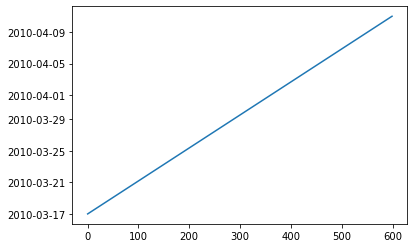

In [8]:
plt.plot(range(600),midAt.time_counter)

In [10]:
def detrend(da, dim, detrend_type="constant"):
    """Detrend a DataArray
    Parameters
    ----------
    da : xarray.DataArray
        The data to detrend
    dim : str or list
        Dimensions along which to apply detrend.
        Can be either one dimension or a list with two dimensions.
        Higher-dimensional detrending is not supported.
        If dask data are passed, the data must be chunked along dim.
    detrend_type : {'constant', 'linear'}
        If ``constant``, a constant offset will be removed from each dim.
        If ``linear``, a linear least-squares fit will be estimated and removed
        from the data.
    Returns
    -------
    da : xarray.DataArray
        The detrended data.
    Notes
    -----
    This function will act lazily in the presence of dask arrays on the
    input.
    """

    if detrend_type not in ["constant", "linear", None]:
        raise NotImplementedError(
            "%s is not a valid detrending option. Valid "
            "options are: 'constant','linear', or None." % detrend_type
        )

    if detrend_type is None:
        return da
    elif detrend_type == "constant":
        return da - da.mean(dim=dim)
    elif detrend_type == "linear":
        data = da.data
        axis_num = [da.get_axis_num(d) for d in dim]
        chunks = getattr(data, "chunks", None)
        if chunks:
            axis_chunks = [data.chunks[a] for a in axis_num]
            if not all([len(ac) == 1 for ac in axis_chunks]):
                raise ValueError("Contiguous chunks required for detrending.")
        if len(dim) == 1:
            dt = xr.apply_ufunc(
                sps.detrend,
                da,
                axis_num[0],
                output_dtypes=[da.dtype],
                dask="parallelized",
            )
        elif len(dim) == 2:
            dt = xr.apply_ufunc(
                _detrend_2d_ufunc,
                da,
                input_core_dims=[dim],
                output_core_dims=[dim],
                output_dtypes=[da.dtype],
                vectorize=True,
                dask="parallelized",
            )
        else:  # pragma: no cover
            raise NotImplementedError(
                "Only 1D and 2D detrending are implemented so far."
            )

    return dt


def _detrend_2d_ufunc(arr):
    assert arr.ndim == 2
    N = arr.shape

    col0 = np.ones(N[0] * N[1])
    col1 = np.repeat(np.arange(N[0]), N[1]) + 1
    col2 = np.tile(np.arange(N[1]), N[0]) + 1
    G = np.stack([col0, col1, col2]).transpose()

    d_obs = np.reshape(arr, (N[0] * N[1], 1))
    m_est = np.dot(np.dot(spl.inv(np.dot(G.T, G)), G.T), d_obs)
    d_est = np.dot(G, m_est)
    linear_fit = np.reshape(d_est, N)
    return arr - linear_fit


def autocorr(x1,x2,dims=['y','x']):

    x1 -= x1.mean(dims,skipna=True)
    x2 -= x2.mean(dims,skipna=True)
    corr = (x1*x2).sum(dims,skipna=True)
    corr /= (np.sqrt((x1**2).sum(dims,skipna=True))
             * np.sqrt((x2**2).sum(dims,skipna=True))
            )
    return corr

In [11]:
midAdt = detrend(midAt, dim=['y','x'], detrend_type='linear')
midAdu = detrend(midAu, dim=['y','x'], detrend_type='linear')

In [12]:
dt = int(24*5)
lag = int(24*5)
rmidAt = xr.DataArray(np.ones((len(midAdt.time_counter[::dt]),lag)), dims=['time_counter','lag'],
                      coords={'time_counter':midAdt.time_counter[::dt].data,
                              'lag':range(1,lag+1)}
                     )
rmidAu = xr.DataArray(np.ones((len(midAdu.time_counter[::dt]),lag)), dims=['time_counter','lag'],
                    coords={'time_counter':midAdu.time_counter[::dt].data,
                            'lag':range(1,lag+1)}
                   )

for i in range(1,lag+1):
    x1 = midAdt.shift(time_counter=-i)
    rmidAt[:,i-1] = autocorr(midAdt.where(~np.isnan(x1)), x1)[::dt].compute()
    x1 = midAdu.shift(time_counter=-i)
    rmidAu[:,i-1] = autocorr(midAdu.where(~np.isnan(x1)), x1)[::dt].compute()

distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

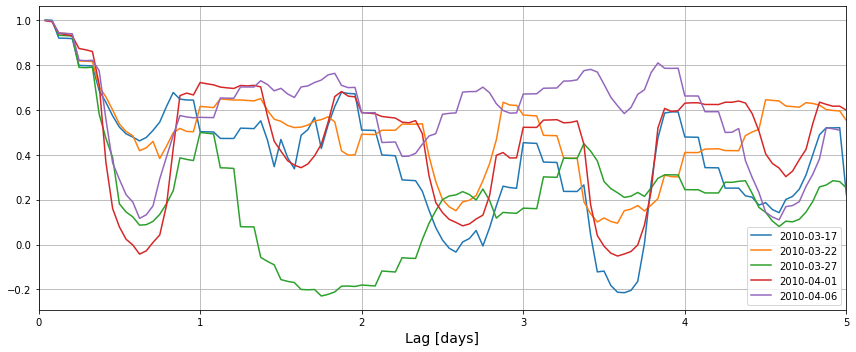

In [13]:
fig, ax = plt.subplots(figsize=(12,5))
fig.set_tight_layout(True)
for j in range(len(rmidAt.time_counter)):
    ax.plot(rmidAt.lag, rmidAt[j], label=str(rmidAt.time_counter[j].data)[:10])
ax.set_xlim([0,lag])
ax.set_xticks([0,24,48,72,96,lag])
ax.set_xticklabels([0,1,2,3,4,5])
ax.set_xlabel(r"Lag [days]", fontsize=14)
ax.legend(loc='lower right', fontsize=10)
ax.grid(True)

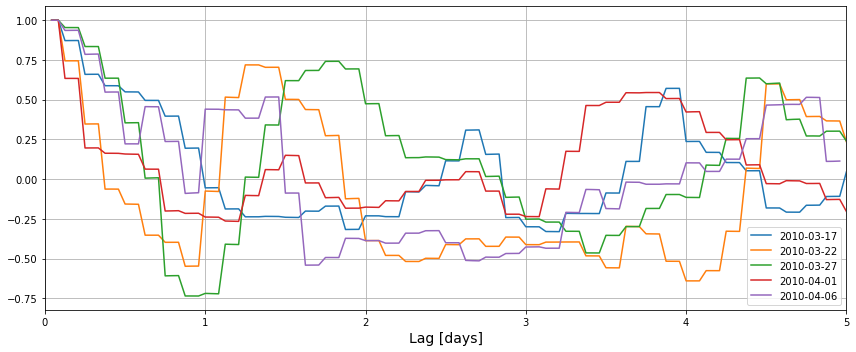

distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


In [14]:
fig, ax = plt.subplots(figsize=(12,5))
fig.set_tight_layout(True)
for j in range(len(rmidAu.time_counter)):
    ax.plot(rmidAu.lag, rmidAu[j], label=str(rmidAu.time_counter[j].data)[:10])
ax.set_xlim([0,lag])
ax.set_xticks([0,24,48,72,96,lag])
ax.set_xticklabels([0,1,2,3,4,5])
ax.set_xlabel(r"Lag [days]", fontsize=14)
ax.legend(loc='lower right', fontsize=10)
ax.grid(True)